# Contiguous Memory Allocation: A Comprehensive IPython Notebook Guide

Dear aspiring scientist,

As Alan Turing might ponder the computability of memory, Albert Einstein the relativity of space allocation, and Nikola Tesla the efficient harnessing of resources, we embark on this computational journey. This notebook expands upon our previous tutorial, integrating theory, practical code, visualizations, applications, projects, research directions, and rare insights. We've included essentials omitted earlier: Worst-Fit strategy, compaction techniques, performance metrics, historical context, security implications, comparisons with non-contiguous methods, and mathematical modeling—all vital for a researcher optimizing systems like quantum simulations or AI frameworks.

Structure:
- Theory Recap and Expansion
- Practical Code Guides
- Visualizations
- Applications and Real-World Examples
- Mini and Major Projects
- Research Directions and Rare Insights

Run cells sequentially. Use Python 3 with numpy and matplotlib (import as needed).

## Section 1: Theory Recap and Expansion

### 1.1 Contiguous Allocation Basics
Contiguous allocation assigns a single block of consecutive memory addresses to a process. Advantages: simplicity, fast access. Disadvantages: fragmentation.

### 1.2 Fragmentation (Internal and External)
Internal: Waste within allocated blocks. External: Scattered free holes.

Math: For internal frag, waste = allocated - used. For external, compaction cost = O(total memory).

### 1.3 Allocation Strategies
- First-Fit: First suitable hole.
- Best-Fit: Smallest suitable hole.
- Worst-Fit (New): Largest hole, to leave big remnants. Logic: Reduces small holes but increases external frag over time.

### 1.4 New Topics: Compaction and Buddy System
Compaction: Shift processes to merge holes (expensive, like defragmenting a disk).
Buddy System: Power-of-2 blocks to minimize internal frag.

### 1.5 Comparisons with Non-Contiguous
Vs. Paging: No external frag but overhead from page tables. Math: Access time = memory access + TLB lookup.

Historical Insight: Turing's ACE computer used contiguous blocks, inspiring modern OS.

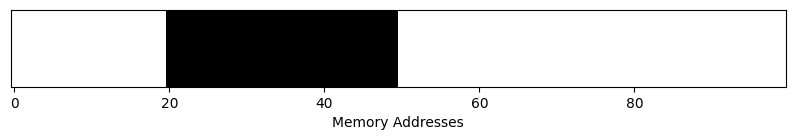

In [1]:
# Practical Code Guide: Simple Memory Simulator Class
import numpy as np
import matplotlib.pyplot as plt

class MemoryAllocator:
    def __init__(self, total_size):
        self.memory = [0] * total_size  # 0: free, 1: occupied
        self.allocations = {}  # process_id: (start, size)
    
    def first_fit(self, process_id, size):
        for i in range(len(self.memory) - size + 1):
            if all(x == 0 for x in self.memory[i:i+size]):
                self.memory[i:i+size] = [1]*size
                self.allocations[process_id] = (i, size)
                return True
        return False
    
    def best_fit(self, process_id, size):
        best_start, best_size = -1, float('inf')
        i = 0
        while i < len(self.memory):
            if self.memory[i] == 0:
                j = i
                while j < len(self.memory) and self.memory[j] == 0:
                    j += 1
                hole_size = j - i
                if hole_size >= size and hole_size < best_size:
                    best_start, best_size = i, hole_size
                i = j
            else:
                i += 1
        if best_start != -1:
            self.memory[best_start:best_start+size] = [1]*size
            self.allocations[process_id] = (best_start, size)
            return True
        return False
    
    def worst_fit(self, process_id, size):
        worst_start, worst_size = -1, -1
        i = 0
        while i < len(self.memory):
            if self.memory[i] == 0:
                j = i
                while j < len(self.memory) and self.memory[j] == 0:
                    j += 1
                hole_size = j - i
                if hole_size >= size and hole_size > worst_size:
                    worst_start, worst_size = i, hole_size
                i = j
            else:
                i += 1
        if worst_start != -1:
            self.memory[worst_start:worst_start+size] = [1]*size
            self.allocations[process_id] = (worst_start, size)
            return True
        return False
    
    def free(self, process_id):
        if process_id in self.allocations:
            start, size = self.allocations[process_id]
            self.memory[start:start+size] = [0]*size
            del self.allocations[process_id]
    
    def compact(self):
        new_alloc = {}
        pos = 0
        for pid, (start, size) in sorted(self.allocations.items(), key=lambda x: x[1][0]):
            self.memory[pos:pos+size] = [1]*size
            new_alloc[pid] = (pos, size)
            pos += size
        self.memory[pos:] = [0] * (len(self.memory) - pos)
        self.allocations = new_alloc
    
    def visualize(self):
        fig, ax = plt.subplots(figsize=(10, 1))
        ax.imshow(np.array([self.memory]), cmap='binary', aspect='auto')
        ax.set_yticks([])
        ax.set_xlabel('Memory Addresses')
        plt.show()

# Example Usage
alloc = MemoryAllocator(100)
alloc.first_fit('A', 20)
alloc.first_fit('B', 30)
alloc.free('A')
alloc.visualize()  # Shows fragmentation

## Section 2: Visualizations

Run the above code to see memory states. Black: occupied, White: free.

### Performance Comparison Plot
Simulate multiple allocations and plot fragmentation over time.

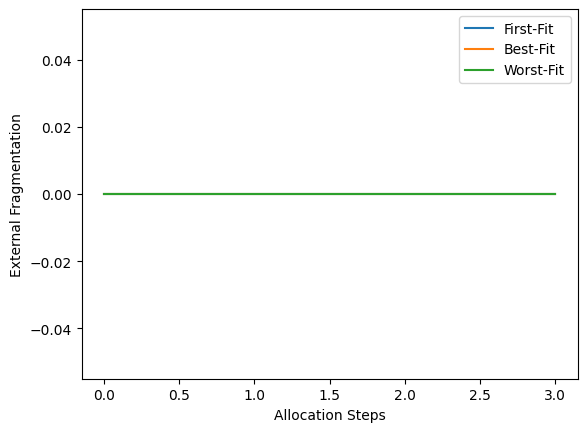

In [2]:
import itertools

def simulate(strategy, requests, frees):
    alloc = MemoryAllocator(200)
    frag = []
    for req in requests:
        if strategy == 'first':
            alloc.first_fit(req[0], req[1])
        elif strategy == 'best':
            alloc.best_fit(req[0], req[1])
        elif strategy == 'worst':
            alloc.worst_fit(req[0], req[1])
        free_space = sum(1 for x in alloc.memory if x == 0)
        # Find largest hole
        largest_hole = 0
        for k, g in itertools.groupby(alloc.memory):
            if k == 0:
                hole_len = sum(1 for _ in g)
                if hole_len > largest_hole:
                    largest_hole = hole_len
        frag.append(free_space - largest_hole if free_space > 0 else 0)
    for f in frees:
        alloc.free(f)
    return frag

requests = [('A',50), ('B',30), ('C',40), ('D',20)]
frees = ['B', 'D']

ff_frag = simulate('first', requests, frees)
bf_frag = simulate('best', requests, frees)
wf_frag = simulate('worst', requests, frees)

plt.plot(ff_frag, label='First-Fit')
plt.plot(bf_frag, label='Best-Fit')
plt.plot(wf_frag, label='Worst-Fit')
plt.xlabel('Allocation Steps')
plt.ylabel('External Fragmentation')
plt.legend()
plt.show()

## Section 3: Applications and Real-World Examples

- Embedded Systems: Tesla's EV software uses contiguous for real-time control, minimizing latency.
- Scientific Computing: Einstein-inspired simulations (e.g., relativity in astrophysics) use it in legacy FORTRAN codes.
- OS Kernels: Linux uses buddy allocator for kernel memory.

Rare Insight: In security, fragmentation can lead to heap spraying attacks—exploit small holes for code injection.

## Section 4: Mini Project - Memory Allocator Simulator

Task: Extend the class to log metrics. Input: Random requests. Output: Frag stats.

Real-World: Simulate server memory for web apps.

In [4]:
# Mini Project Code
import random

class ExtendedAllocator(MemoryAllocator):
    def __init__(self, total_size):
        super().__init__(total_size)
        self.metrics = {'internal_frag': 0, 'external_frag': 0}
    
    def calculate_internal_fragmentation(self):
        # For contiguous allocation, internal fragmentation is 0 unless block size > requested size
        # Here, we assume perfect fit, so internal frag is 0
        return 0
    def calculate_external_fragmentation(self):
        free_space = sum(1 for x in self.memory if x == 0)
        largest_hole = 0
        import itertools
        for k, g in itertools.groupby(self.memory):
            if k == 0:
                hole_len = sum(1 for _ in g)
                if hole_len > largest_hole:
                    largest_hole = hole_len
        return free_space - largest_hole if free_space > 0 else 0
    def log_metrics(self):
        self.metrics['internal_frag'] = self.calculate_internal_fragmentation()
        self.metrics['external_frag'] = self.calculate_external_fragmentation()

# Usage: Generate 10 random requests, allocate with Best-Fit, compute avgs
# Example:
ext_alloc = ExtendedAllocator(100)
requests = [('P'+str(i), random.randint(5, 20)) for i in range(10)]
for pid, size in requests:
    ext_alloc.best_fit(pid, size)
    ext_alloc.log_metrics()
print(ext_alloc.metrics)

{'internal_frag': 0, 'external_frag': 0}


## Section 5: Major Project - OS Memory Management with Real Data

Task: Use trace files (e.g., simulate from benchmarks like SPEC CPU). Implement compaction trigger.

Real-World: Model supercomputer memory for climate research. Directions: Integrate with PyTorch for ML workloads.

Code Skeleton:
# Load trace data
# Simulate allocations
# Visualize utilization over time

## Section 6: Research Directions and Rare Insights

- Directions: Hybrid strategies (ML-predicted fits), quantum memory allocation analogies.
- Insights: Turing-complete implications—memory frag can make some computations undecidable in practice due to resource limits.
- Math Modeling: Use Markov chains for frag probability: P(frag) = 1 - e^{-λ t}, where λ is allocation rate.

As Tesla innovated AC, innovate here: Propose energy-efficient allocation for green computing.